# Microflown and Microphone with CW 40 KHz piezo

In [165]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

# New function definitions

In [166]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

from constants import kB
from scipy.integrate import cumulative_trapezoid

reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

def psd_calibration(fname, channel="X",
                   fmin=5e2, fmax=4e4, cutoff=1e6,  taumax=100e-3,freq_xnoise2=2e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    C = Collection(fname)
    C.set_collection(channel)
    Tavg = np.mean(C.T)
    if Tavg < 273.15:
        Tavg += 273.15
    Npts = int(C.r / (2*cutoff))
    C.apply("detrend", inplace=True, mode="constant")
    #C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>freq_xnoise2])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker="o", ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq, plot_psd, **dplot_kwargs)
        
        fplot_kwargs = dict(c=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

# Directory structure

In [167]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220523']

In [168]:
# Select a date
date_der_index = 4
experiment_ders = find_ders(date_ders[date_der_index])
experiment_ders

['/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq_narrow',
 '/data/brownian/20220614/muflown-muphone_baseline']

# Baseline (room noise)

In [169]:
fname0 = '/data/brownian/20220614/muflown-muphone_baseline/iter_0.tdms'

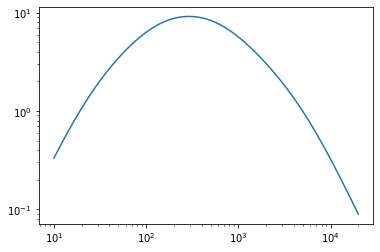

In [170]:
fs = np.geomspace(10, 20000, 500)
plt.loglog(fs, muflown_sensitivity(fs))

In [228]:
T = np.mean(C0Ph.T)
Z0 = get_air_density(T, RH=0*C0Ph.cRH) * get_sound_speed(T, RH=0*C0Ph.cRH, p=C0Ph.cP)
Z0

412.36916016542955

In [231]:
C0Fl = Collection(fname0)
C0Fl.set_collection("X")
C0Fl.apply("bin_average", Npts=100, inplace=True)
C0Fl.apply("detrend", mode="constant", inplace=True)
C0Fl.apply("correct", response=muflown_response, n_jobs=1, recollect=True)

C0Ph = Collection(fname0)
C0Ph.set_collection("Y")
C0Ph.apply("correct", response=mic_response, n_jobs=1, recollect=True)
C0Ph.apply("bin_average", Npts=100, inplace=True)
C0Ph.apply("detrend", mode="constant", inplace=True)

C0s = [C0Fl, C0Ph]

In [232]:
C0Fl.average("PSD", taumax=100e-3, n_jobs=2)
C0Ph.average("PSD", taumax=100e-3, n_jobs=2)

(array([0.00000000e+00, 1.19211279e+01, 2.38422558e+01, ...,
        1.26232823e+05, 1.26244745e+05, 1.26256666e+05]),
 array([3.98294698e-02, 1.06442573e-01, 5.52686732e-02, ...,
        2.22427148e-08, 2.35157696e-08, 3.00343493e-08]))

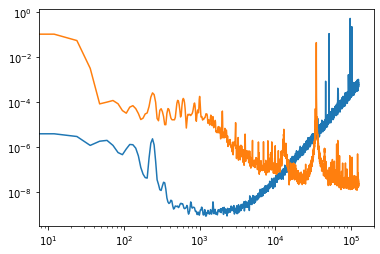

In [233]:
plt.loglog(C0Fl.freq, (Z0)**2*C0Fl.psd)
plt.loglog(C0Ph.freq, C0Ph.psd)

# Frequency scan (near resonance)

In [200]:
cutoff = 300e3
taumax = 80e-3
Deltaf = 500

# Baseline reference
C0Fl = Collection(fnames[0])
C0Fl.set_collection("X")
C0Fl.apply("bin_average", Npts=C0Fl.r // (2*cutoff), inplace=True)
C0Fl.apply("detrend", mode="constant", inplace=True)
C0Fl.apply("correct", response=muflown_response, recollect=True)

C0Ph = Collection(fname0)
C0Ph.set_collection("Y")
C0Ph.apply("calibrate", cal=1/mic_sensitivity, inplace=True)
C0Ph.apply("bin_average", Npts=C0Ph.r // (2*cutoff), inplace=True)
C0Ph.apply("detrend", mode="constant", inplace=True)

C0Fl.average("PSD", taumax=taumax)
C0Ph.average("PSD", taumax=taumax)

C0s = [C0Fl, C0Ph]

In [201]:
fnames

['/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_0.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_1.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_2.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_3.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_4.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_5.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_6.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_7.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_8.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_9.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_10.tdms',
 '/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq/iter_11.tdms',
 '/data/brownian/20220614/

In [202]:
exp_fnames = find_files('/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq_narrow')
amps = []
foss = []
fnames = []
for fname in sort_fnames(exp_fnames):
    C = Collection(fname)
    fos = C.fos
    foss.append(fos)
    amps.append(C.amp)
    fnames.append(fname)
foss = np.unique(foss)
amps = np.unique(amps)

In [203]:
# Convert to pressure data and compute PSD
chanels = ["X", "Y"]
names = ["flown", "phone"]
fnamei = -1
Cs = np.zeros((len(chanels), len(foss), len(amps)), dtype="object")
for fosi, fos in enumerate(foss):
    for ampi, amp in enumerate(amps):
        fnamei += 1
        for chi, (chanel, name) in enumerate(zip(chanels, names)):
            C = Collection(fnames[fnamei])
            C.set_collection(chanel)
            if name == "flown":
                C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
                C.apply("detrend", mode="constant", inplace=True)
                C.apply("correct", response=muflown_response, recollect=True)
            else:
                C.apply("calibrate", cal=1/mic_sensitivity, inplace=True)
                C.apply("detrend", inplace=True, mode="constant")
                C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
            C.average("PSD", taumax=taumax)
            Cs[chi, fosi, ampi] = C

30000.0 9.0 312.39377546251467
32000.0 9.0 464.4874461383002
34000.0 9.0 79.01329831869755
36000.0 9.0 337.5407091524345
38000.0 9.0 3342.706144111949
40000.0 9.0 210448.4709576603
42000.0 9.0 669007.8099022261
44000.0 9.0 21845.72941203894
46000.0 9.0 4526.577663206856
48000.0 9.0 3409.431199148756


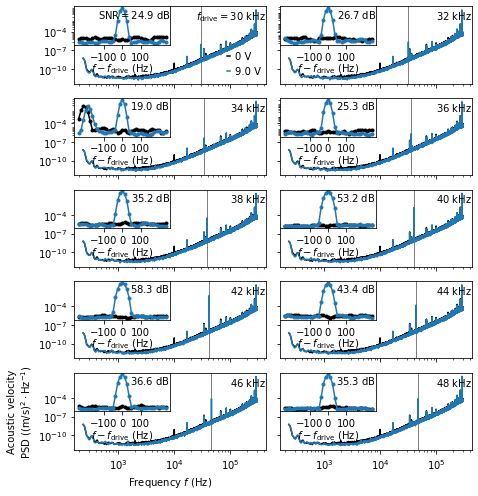

30000.0 9.0 694489.4480127001
32000.0 9.0 2147018.3527746997
34000.0 9.0 6749112.09025819
36000.0 9.0 31820674.25691612
38000.0 9.0 12003277.853000212
40000.0 9.0 1070645131.817992
42000.0 9.0 10411021948.292269
44000.0 9.0 1123565391.5169876
46000.0 9.0 781604498.7650244
48000.0 9.0 119384452.11556591


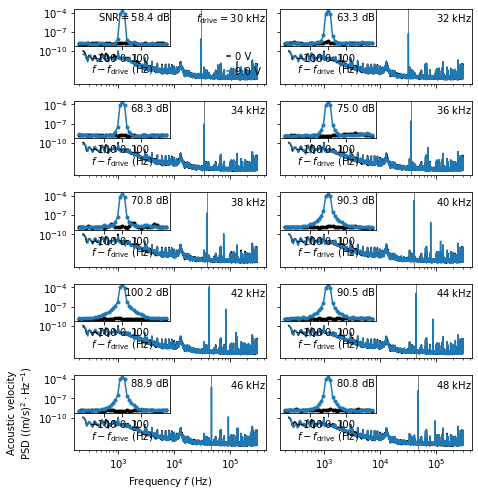

<ipython-input-204-3de9fdb7e521>:54: RuntimeWarning: divide by zero encountered in log10
  dB_SNRs = 10*np.log10(SNRs)


In [204]:
Nrow, Ncol = len(foss)//2, 2

SNRs = np.zeros((len(chanels), len(foss), len(amps)))
for chi, (chanel, name) in enumerate(zip(chanels, names)):
    fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 7), sharex=True, sharey=True)
    C0 = C0s[chi]
    for fosi, fos in enumerate(foss[:-1]):
        fos *= 1e3
        r = fosi // Ncol
        c = fosi % Ncol
        ax = axs[r, c]
        inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
        mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
        inmask0 = np.logical_and(C0.freq>fos-Deltaf/2, C0.freq<min(fos+Deltaf/2, 2.0e6))
        ax.loglog(C0.freq[mask0], C0.psd[mask0], c="k", label="0 V")
        inax.plot(C0.freq[inmask0]-fos, C0.psd[inmask0]*1e6, marker=".", c="k")
        ax.axvline(fos, lw=0.5, c="k")
        for ampi, amp in enumerate(amps):
            color = f"C{ampi}"
            C = Cs[chi, fosi, ampi]
            freq, psd = C.freq, C.psd
            inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

            mask = np.logical_and(freq<cutoff, freq>230)
            ax.loglog(freq[mask], psd[mask], label="%s V"%amp, c=color)
            #ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
            inax.semilogy(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
            max_dex = np.argmax(psd[inmask])
            mx = psd[inmask][max_dex]
            mn = C0.psd[inmask0][max_dex]
            SNR = mx/mn
            SNRs[chi, fosi, ampi] = SNR
            print(fos, amp, SNR)
            if c==0 and r==0:
                drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
                SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
            else:
                drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
                SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
            if ampi == len(amps)-1:
                ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
                inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
            inax.set_yticks([])
            inax.set_xticks([-100, 0, 100])
            inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
    #axs[-1,0].set_yscale("log")
    axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
    axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
    axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
    axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
    plt.tight_layout()
    #plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
    plt.show()
dB_SNRs = 10*np.log10(SNRs)

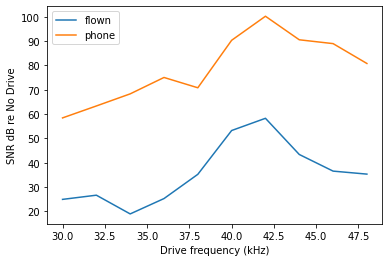

In [205]:
for chi, (chanel, name) in enumerate(zip(chanels, names)):
    plt.plot(foss, factor*dB_SNRs[chi, :,-1], label=name)
plt.xlabel("Drive frequency (kHz)")
plt.ylabel("SNR dB re No Drive")
plt.legend()

# Frequency scan (wide)

In [194]:
cutoff = 300e3
taumax = 80e-3
Deltaf = 500

# Baseline reference
C0Fl = Collection(fnames[0])
C0Fl.set_collection("X")
C0Fl.apply("bin_average", Npts=C0Fl.r // (2*cutoff), inplace=True)
C0Fl.apply("detrend", mode="constant", inplace=True)
C0Fl.apply("correct", response=muflown_response, recollect=True)

C0Ph = Collection(fname0)
C0Ph.set_collection("Y")
C0Ph.apply("calibrate", cal=1/mic_sensitivity, inplace=True)
C0Ph.apply("bin_average", Npts=C0Ph.r // (2*cutoff), inplace=True)
C0Ph.apply("detrend", mode="constant", inplace=True)

C0Fl.average("PSD", taumax=taumax)
C0Ph.average("PSD", taumax=taumax)

C0s = [C0Fl, C0Ph]


In [190]:
exp_fnames = find_files('/data/brownian/20220614/muflown-muphone_CW-40kHz-piezo_scan-freq')
amps_wide = []
foss_wide = []
fnames = []
for fname in sort_fnames(exp_fnames):
    C = Collection(fname)
    fos = C.fos
    foss_wide.append(fos)
    amps_wide.append(C.amp)
    fnames.append(fname)
foss_wide = np.unique(foss_wide)
amps_wide = np.unique(amps_wide)

In [191]:
# Convert to pressure data and compute PSD
chanels = ["X", "Y"]
names = ["flown", "phone"]
fnamei = -1
Cs_wide = np.zeros((len(chanels), len(foss_wide), len(amps_wide)), dtype="object")
for fosi, fos in enumerate(foss_wide):
    for ampi, amp in enumerate(amps_wide):
        fnamei += 1
        for chi, (chanel, name) in enumerate(zip(chanels, names)):
            C = Collection(fnames_wide[fnamei])
            C.set_collection(chanel)
            if name == "flown":
                C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
                C.apply("detrend", mode="constant", inplace=True)
                C.apply("correct", response=muflown_response, recollect=True)
            else:
                C.apply("calibrate", cal=1/mic_sensitivity, inplace=True)
                C.apply("detrend", inplace=True, mode="constant")
                C.apply("bin_average", Npts=C.r // (2*cutoff), inplace=True)
            C.average("PSD", taumax=taumax)
            Cs_wide[chi, fosi, ampi] = C

10000.0 9.0 1.0
12385.989684455542 9.0 76.51207370149825
15341.274046343908 9.0 14.423527851051631
19001.68620844212 9.0 17.937792766366
23535.468936502522 9.0 1.7514283919784475
29151.007546634413 9.0 629.2185013722386
36106.40787640995 9.0 880.2648923853553
44721.359549995796 9.0 2430.52746807764
55391.829806107526 9.0 627.6068507962422
68608.2632581565 9.0 309.28782146877904
84978.12409839363 9.0 3.287109394641559
105253.81684870865 9.0 7.634755097478809
130367.2689737678 9.0 1.5596480373396766
161472.76486997298 9.0 1.2979175142531385
200000.0 9.0 2.0788860206828956


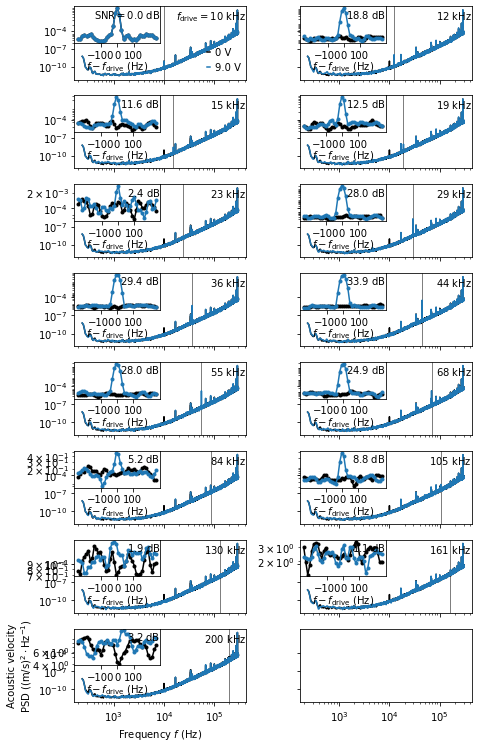

10000.0 9.0 0.17586621597819313
12385.989684455542 9.0 3.425459305548915
15341.274046343908 9.0 8.79813156737587
19001.68620844212 9.0 387.6322871811941
23535.468936502522 9.0 3085.15365585016
29151.007546634413 9.0 128830.4157551965
36106.40787640995 9.0 1629114.7020921141
44721.359549995796 9.0 111127783.86277665
55391.829806107526 9.0 3976783.573338168
68608.2632581565 9.0 11373946.93638518
84978.12409839363 9.0 2440203.3222119445
105253.81684870865 9.0 3358334.0306181754
130367.2689737678 9.0 168792.54541486097
161472.76486997298 9.0 149628.61003736325
200000.0 9.0 17.155293245002486


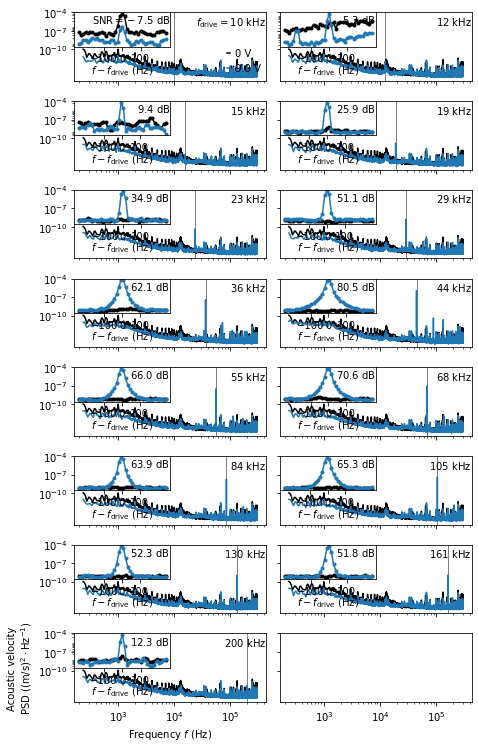

In [208]:
Nrow, Ncol = len(foss_wide)//2+1, 2

SNRs_wide = np.zeros((len(chanels), len(foss_wide), len(amps_wide)))
for chi, (chanel, name) in enumerate(zip(chanels, names)):
    fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 1.5*7), sharex=True, sharey=True)
    C0 = C0s[chi]
    for fosi, fos in enumerate(foss_wide[:]):
        fos *= 1e3
        r = fosi // Ncol
        c = fosi % Ncol
        ax = axs[r, c]
        inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
        mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
        inmask0 = np.logical_and(C0.freq>fos-Deltaf/2, C0.freq<min(fos+Deltaf/2, 2.0e6))
        ax.loglog(C0.freq[mask0], C0.psd[mask0], c="k", label="0 V")
        inax.plot(C0.freq[inmask0]-fos, C0.psd[inmask0]*1e6, marker=".", c="k")
        ax.axvline(fos, lw=0.5, c="k")
        for ampi, amp in enumerate(amps_wide):
            color = f"C{ampi}"
            C = Cs_wide[chi, fosi, ampi]
            freq, psd = C.freq, C.psd
            inmask = np.logical_and(freq>fos-Deltaf/2, freq<min(fos+Deltaf/2, 2.0e6))

            mask = np.logical_and(freq<cutoff, freq>230)
            ax.loglog(freq[mask], psd[mask], label="%s V"%amp, c=color)
            #ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
            inax.semilogy(freq[inmask]-fos, psd[inmask]*1e6, marker=".", c=color)
            max_dex = np.argmax(psd[inmask])
            mx = psd[inmask][max_dex]
            mn = C0.psd[inmask0][max_dex]
            SNR = mx/mn
            SNRs_wide[chi, fosi, ampi] = SNR
            print(fos, amp, SNR)
            if c==0 and r==0:
                drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fos/1e3)) 
                SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
            else:
                drive_str = r"$%s$ kHz" % (int(fos/1e3)) 
                SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
            if ampi == len(amps)-1:
                ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
                inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
            inax.set_yticks([])
            inax.set_xticks([-100, 0, 100])
            inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
    #axs[-1,0].set_yscale("log")
    axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
    axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
    axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
    axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
    plt.tight_layout()
    #plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")
    plt.show()
dB_SNRs_wide = 10*np.log10(SNRs_wide)

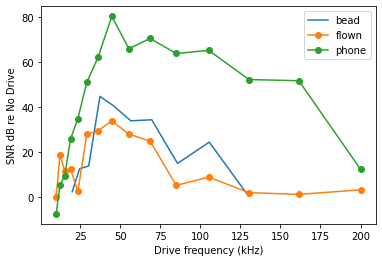

In [217]:

foss_b, SNRs_b = np.array([
    [20000.0, 1.7089395744129512],
    [24623.72214713907, 18.07183070099135],
    [30316.384618975357, 23.93364799144118],
    [37325.111568172484, 30044.91652725583],
    [45954.15881828227, 11242.153865535125],
    [56578.12191234416, 2456.4625173315476],
    [69658.19767882615, 2733.5071052969874],
    [85762.20524569515, 31.112332446496236],
    [105589.2356347955, 275.7708375526359],
    [130000.0, 1.1147814454217435]
]).T
dB_SNRs_b = 10*np.log10(SNRs_b)


plt.plot(foss_b/1e3, dB_SNRs_b, label="bead")

for chi, (chanel, name) in enumerate(zip(chanels, names)):
    plt.plot(foss_wide, factor*dB_SNRs_wide[chi, :,-1], label=name, marker="o")
plt.xlabel("Drive frequency (kHz)")
plt.ylabel("SNR dB re No Drive")

#for chi, (chanel, name) in enumerate(zip(chanels, names)):
#    plt.plot(foss, factor*dB_SNRs[chi, :,-1], label=name, marker="o")
plt.xlabel("Drive frequency (kHz)")
plt.ylabel("SNR dB re No Drive")


plt.legend()